# 7. 集成学习

集成学习(ensemble learning)通过构建并结合多个学习器来完成学习任务，有时也被称为多分类器系统(multi-classifier system)、基于委员会的学习(committee-based learning)等。

下图显示出集成学习的一般性结构：先产生一组“个体学习器”(individual learner)，再用某种策略将他们结合起来。集成中只包含同种类型的个体学习器，例如“决策树集成”中全是决策树，这样的集成是同质的(homogeneous)。同质集成中的个体学习器亦称“基学习器”(base learning)，相应的学习算法被称为“基学习算法”(base learning algorithm)。集成也可以包含不同类型的个体学习器，例如同时包含决策树和神经网络，这样的集成是“异质”的(heterogenous)。异质集成中的个体学习器由不同的学习算法生成，这时就不再有基学习算法；相应的，个体学习器不再称为基学习器，常称为“组件学习器”(component learner)或直接称为个体学习器。
![](ensemble-learning.png)
目前的集成学习方法大致分为两类：
1. 个体学习器间存在强依赖关系，必须串行生成的序列化方法
2. 个体学习器将不存在强依赖关系，可同时生成并行化方法

1的代表是Boosting，2的代表是Bagging和“随机森林”(Random Forest)

## 7.1. Boosting
Boosting是一族可将弱学习器提升为强学习器的算法。这族算法的工作机制类似：先从初始训练集训练出一个基学习器，再根据基学习器的表现对训练样本分布进行调整，使得先前基学习器做错的训练样本在后续受到更多关注，然后基于调整后的样本分布来训练下一个基学习器；如此反复进行，直至基学习器数目达到事先指定的值T，最终将这T个基学习器进行加权结合。Boosting族算法最著名的代表是AdaBoost。

AdaBoost：运行过程如下：为训练集中的每个样本赋予一个权重alpha，这些权重组成了向量D，向量D中的权重初始值相同。首先在训练数据上训练出一个若分类器并计算错误率，然后在同一数据集上再次训练弱分类器。第二次训练时会调整每个样本的权重，第一次分类正确的样本权重会降低，分类错误的样本的权重会提高（重点关注分类错误的样本）。  
错误率定义为：$\varepsilon=\frac{未正确分类的样本数目}{所有样本数目}$  
alpha的计算公式：$\alpha=\frac{1}{2}\ln\big(\frac{1-\varepsilon}{\varepsilon}\big)$  
计算出alpha值之后，可以对权重向量D进行更新，以使得正确分类样本的权重降低；错误分类的样本升高。  
如果某个样本被分类正确，则权重更新为：$D_i^{(t+1)}=\frac{D_i^{(t)e^{-a}}}{Sum(D)}$  
如果某个样本被分类错误，则权重更新为：$D_i^{(t+1)}=\frac{D_i^{(t)e^a}}{Sum(D)}$

## 7.2. 基于单层决策树构建弱分类器

### 7.2.1. 单层决策树
也叫作决策树桩(decision stump)。它仅基于单个特征来做决策。以西瓜数据为例：  

| 编号 | 色泽 | 根蒂 | 好瓜 |  
| :---: | :---: | :---: | :---: |
| 1 | 青绿 | 蜷缩 | 是 |
| 2 | 乌黑 | 蜷缩 | 是 |
| 3 | 乌黑 | 稍蜷 | 是 |
| 4 | 乌黑 | 稍蜷 | 否 |
| 5 | 青绿 | 硬挺 | 否 |

那么树桩可以选择色泽或根蒂作为判断的准则，以树桩的判断属性为色泽为例，判断色泽为青绿的瓜为坏瓜，色泽为乌黑的瓜为好瓜。

| 编号 | x1 | x2 | good |  
| :---: | :---: | :---: | :---: |
| 1 | 1 | 2.1 | 是 |
| 2 | 2 | 1.1 | 是 |
| 3 | 1.3 | 1 | 否 |
| 4 | 1 | 1 | 否 |
| 5 | 2 | 1 | 是 |

以数值型的数据为例，在这种情况下，可以以x1或x2作为树桩，以x1=1.5为分界线可以得到一个

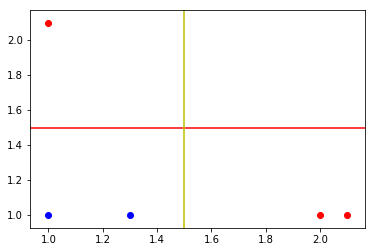

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.DataFrame([[1,2.1,1],
                 [2.1,1,1],
                 [1.3,1,-1],
                 [1,1,-1],
                 [2,1,1]])
# data[0,:]
d1 = data[data[2]==1]
d2 = data[data[2]==-1]

x1 = 1.5
y1 = [i for i in np.arange(1,2.1,0.1)]

plt.scatter(d1[0],d1[1],c='r')
plt.scatter(d2[0],d2[1],c='b')

plt.axhline(y=1.5, color='black', linestyle='-')
plt.axvline(x=1.5, color='y', linestyle='-')
plt.show()